In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

In [2]:
def add_ticks(axes_axis):
    axes_axis.set_ticks([10, 20, 30, 40, 50, 60, 70., 80, 90.])
    axes_axis.set_minor_locator(mtick.FixedLocator([5, 15, 25, 35, 45, 55, 65, 75, 85]))
    axes_axis.set_minor_formatter(mtick.FixedFormatter(['.01%', '.02%', '.05%', '0.1%', '0.2%', '0.5%', '1.0%', '2.0%', '5.0%']))

In [3]:
npzfile = np.load('picky_observed_differences_from_expected.npz')

In [4]:
npzfile.files

['empty_droplet_diffs', 'picky_group_diffs', 'multi_strain_droplet_diffs']

In [5]:
empty_droplet_diffs = npzfile['empty_droplet_diffs']

In [6]:
empty_droplet_diffs.shape

(500,)

In [7]:
multi_strain_droplet_diffs = npzfile['multi_strain_droplet_diffs']

In [8]:
multi_strain_droplet_diffs.shape

(500,)

In [9]:
picky_group_diffs = npzfile['picky_group_diffs']

In [10]:
picky_group_diffs.shape

(500, 91, 91)

In [11]:
base_relative_abundances = [1e-4, 1e-3, 1e-2]

relative_abundances = [relative_abundance * number
                       for relative_abundance 
                       in base_relative_abundances
                       for number in (1,2,5) 
                       for repeat in range(10)]

relative_abundances += [1-sum(relative_abundances)]
frequencies = np.array(relative_abundances)

rate = 2

number_droplets = int(15e6)

In [12]:
from simulations.global_chi2_cpm import get_expected_counts

In [13]:
expected_counts = get_expected_counts(number_droplets=number_droplets, frequency_vector=frequencies, rate=rate)

In [14]:
empty_droplets_expected = expected_counts[0]

In [15]:
empty_droplets_expected

2030029.2485491906

In [16]:
multi_strain_droplets_expected = expected_counts[-1]

In [17]:
multi_strain_droplets_expected

4495144.824313902

In [18]:
picky_groups_expected = expected_counts[1]

In [19]:
picky_groups_expected

array([[4.06046453e+02, 8.12174121e-02, 8.12174121e-02, ...,
        4.27042782e+01, 4.27042782e+01, 1.01946497e+02],
       [0.00000000e+00, 4.06046453e+02, 8.12174121e-02, ...,
        4.27042782e+01, 4.27042782e+01, 1.01946497e+02],
       [0.00000000e+00, 0.00000000e+00, 4.06046453e+02, ...,
        4.27042782e+01, 4.27042782e+01, 1.01946497e+02],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.13500040e+05, 2.24539952e+04, 5.36036726e+04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.13500040e+05, 5.36036726e+04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 5.09681513e+05]])

In [20]:
picky_groups_expected.shape

(91, 91)

In [21]:
np.sum(picky_groups_expected) + empty_droplets_expected + multi_strain_droplets_expected

15000000.0

In [22]:
picky_group_diffs.shape

(500, 91, 91)

In [23]:
reshape_picky_groups_expected = picky_groups_expected.reshape((1,*picky_groups_expected.shape))

In [24]:
reshape_picky_groups_expected.shape

(1, 91, 91)

In [25]:
pct_diffs = picky_group_diffs / (reshape_picky_groups_expected + (reshape_picky_groups_expected == 0))

In [26]:
pct_diffs.shape

(500, 91, 91)

In [27]:
avg_pct_diffs = np.mean(pct_diffs, axis=0)

In [28]:
median_pct_diffs = np.median(pct_diffs, axis=0)

In [29]:
avg_pct_diffs.shape

(91, 91)

Text(0.5, 1.0, 'hTPMH')

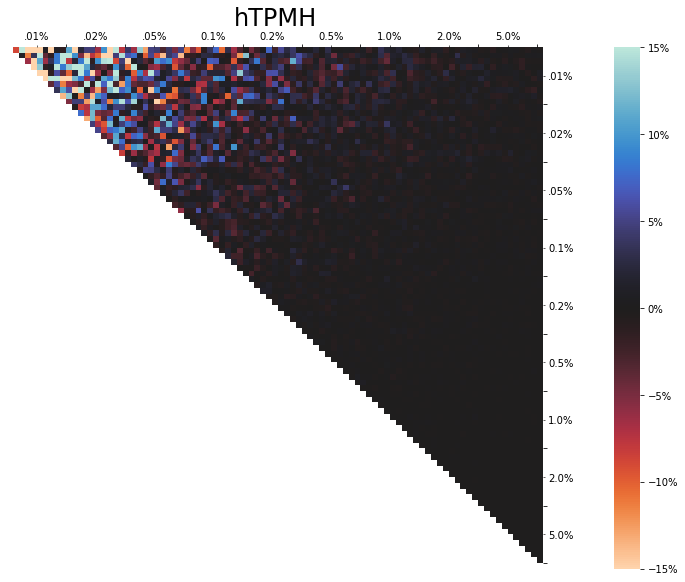

In [30]:
plt.figure(figsize=(12.8,9.6))

ax = sns.heatmap(avg_pct_diffs, 
                 mask=np.tril(np.ones((frequencies.size, frequencies.size)).astype(bool), k=0),
                cmap='icefire_r', cbar_kws={'pad':0.1}, vmin=-0.15, vmax=0.15)
ax.yaxis.tick_right()
ax.xaxis.tick_top()

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))

add_ticks(ax.xaxis)
add_ticks(ax.yaxis)
plt.title('hTPMH', fontsize=24)

Text(0.5, 1.0, 'hTPMH')

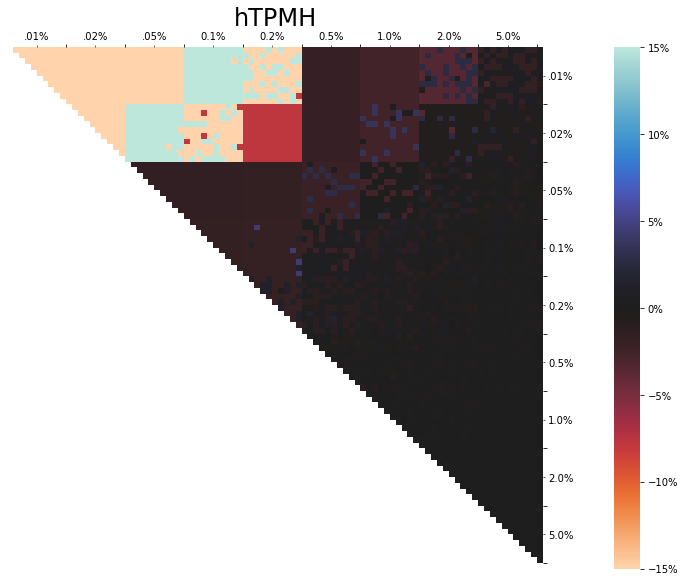

In [31]:
plt.figure(figsize=(12.8,9.6))

ax = sns.heatmap(median_pct_diffs, 
                 mask=np.tril(np.ones((frequencies.size, frequencies.size)).astype(bool), k=0),
                cmap='icefire_r', cbar_kws={'pad':0.1}, vmin=-0.15, vmax=0.15)
ax.yaxis.tick_right()
ax.xaxis.tick_top()

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))

add_ticks(ax.xaxis)
add_ticks(ax.yaxis)
plt.title('hTPMH', fontsize=24)

## grouping by abundance of strain, rather than strain itself per se

In [32]:
pct_diffs.shape

(500, 91, 91)

In [33]:
def get_grouped_pct_diffs(pct_diffs):
    grouped_pct_diffs = {}
    for i in range(9):
        for j in range(i,9):
            if i != j:
                grouped_pct_diffs[i,j] = pct_diffs[:,i*10:(i+1)*10,j*10:(j+1)*10]
            elif i == j:
                grouped_pct_diffs[i,j] = np.array([])
                for simulation_number in range(500):
                    grouped_pct_diffs[i,j] = np.append(grouped_pct_diffs[i,j], pct_diffs[simulation_number,...][i*10:(i+1)*10,j*10:(j+1)*10][np.triu_indices(10, k=0)])
    return grouped_pct_diffs

In [34]:
grouped_pct_diffs = get_grouped_pct_diffs(pct_diffs)

In [35]:
avg_pct_diffs_grouped = np.zeros((9,9))
median_pct_diffs_grouped = np.zeros((9,9))

for i in range(9):
    for j in range(i,9):
        avg_pct_diffs_grouped[i,j] = np.mean(grouped_pct_diffs[i,j])
        
for i in range(9):
    for j in range(i,9):
        median_pct_diffs_grouped[i,j] = np.median(grouped_pct_diffs[i,j])

Text(0.5, 1.0, 'average across strains with same abundances - hTPMH')

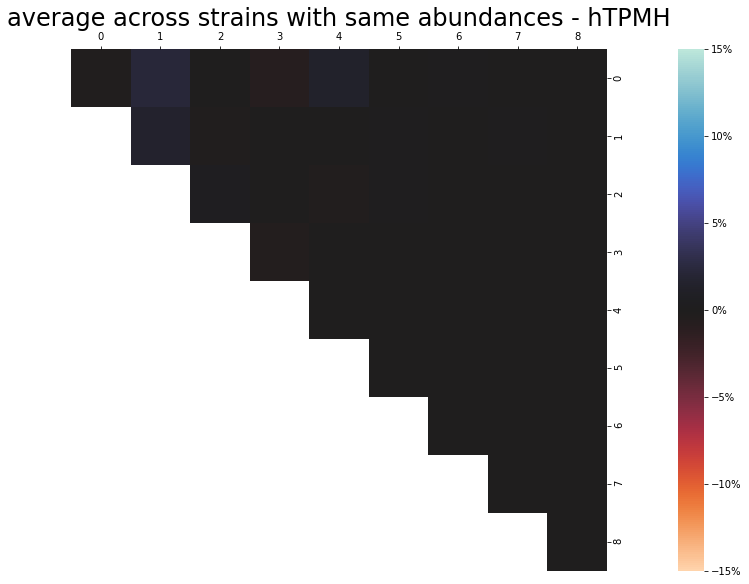

In [36]:
plt.figure(figsize=(12.8,9.6))

ax = sns.heatmap(avg_pct_diffs_grouped, 
                 mask=np.tril(np.ones((9,9)).astype(bool), k=-1),
                cmap='icefire_r', cbar_kws={'pad':0.1}, vmin=-0.15, vmax=0.15)
ax.yaxis.tick_right()
ax.xaxis.tick_top()

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))

#add_ticks(ax.xaxis)
#add_ticks(ax.yaxis)
plt.title('average across strains with same abundances - hTPMH', fontsize=24)

Text(0.5, 1.0, 'average across strains with same abundances - hTPMH')

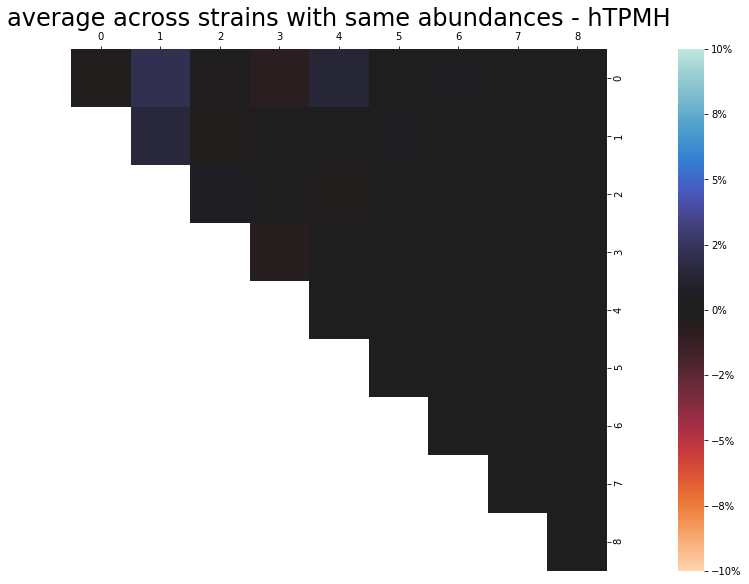

In [37]:
plt.figure(figsize=(12.8,9.6))

ax = sns.heatmap(avg_pct_diffs_grouped, 
                 mask=np.tril(np.ones((9,9)).astype(bool), k=-1),
                cmap='icefire_r', cbar_kws={'pad':0.1}, vmin=-0.1, vmax=0.1)
ax.yaxis.tick_right()
ax.xaxis.tick_top()

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))

#add_ticks(ax.xaxis)
#add_ticks(ax.yaxis)
plt.title('average across strains with same abundances - hTPMH', fontsize=24)

Text(0.5, 1.0, 'median across strains with same abundances - hTPMH')

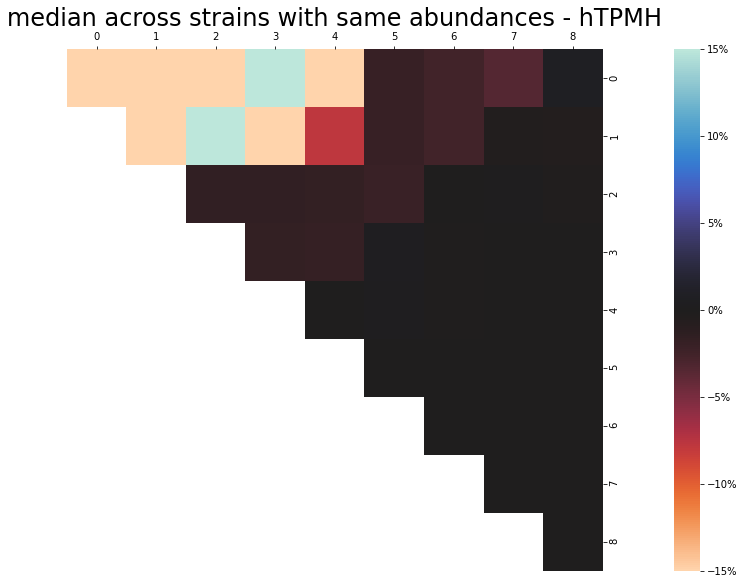

In [38]:
plt.figure(figsize=(12.8,9.6))

ax = sns.heatmap(median_pct_diffs_grouped, 
                 mask=np.tril(np.ones((9,9)).astype(bool), k=-1),
                cmap='icefire_r', cbar_kws={'pad':0.1}, vmin=-0.15, vmax=0.15)
ax.yaxis.tick_right()
ax.xaxis.tick_top()

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))

#add_ticks(ax.xaxis)
#add_ticks(ax.yaxis)
plt.title('median across strains with same abundances - hTPMH', fontsize=24)

Text(0.5, 1.0, 'median across strains with same abundances - hTPMH')

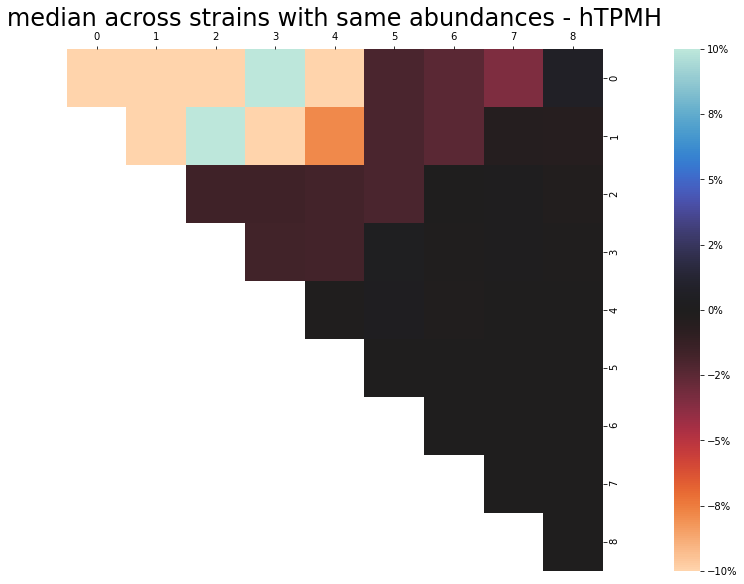

In [39]:
plt.figure(figsize=(12.8,9.6))

ax = sns.heatmap(median_pct_diffs_grouped, 
                 mask=np.tril(np.ones((9,9)).astype(bool), k=-1),
                cmap='icefire_r', cbar_kws={'pad':0.1}, vmin=-0.1, vmax=0.1)
ax.yaxis.tick_right()
ax.xaxis.tick_top()

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))

#add_ticks(ax.xaxis)
#add_ticks(ax.yaxis)
plt.title('median across strains with same abundances - hTPMH', fontsize=24)

### Other random things I don't honestly remember

In [40]:
expected_categories = np.zeros(4)

In [41]:
expected_categories[1] = np.sum(np.diag(expected_counts[1]))

In [42]:
expected_categories[2] = np.sum(expected_counts[1]) - expected_categories[1]

In [43]:
expected_categories[2] == np.sum(expected_counts[1]) - np.sum(np.diag(expected_counts[1]))

True

In [44]:
expected_categories[0] = expected_counts[0]
expected_categories[3] = expected_counts[2]

In [45]:
1 - .65940123

0.34059877000000005

In [46]:
expected_categories

array([2030029.24854919, 4241764.65940123, 4233061.26773568,
       4495144.8243139 ])

In [47]:
np.sum(expected_categories)

14999999.999999996

In [48]:
expected_category_pcts = expected_categories/np.sum(expected_categories)
expected_category_pcts

array([0.13533528, 0.28278431, 0.28220408, 0.29967632])

In [49]:
observed_categories = np.zeros((500,4))

In [50]:
observed_diffs = np.zeros((500,4))

In [51]:
observed_diffs[...,0] = empty_droplet_diffs

In [52]:
observed_diffs[...,3] = multi_strain_droplet_diffs

In [53]:
for i in range(500):
    total_1_or_2_strain_diffs = np.sum(picky_group_diffs[i,...])
    single_strain_diffs = np.sum(np.diag(picky_group_diffs[i,...]))
    double_strain_diffs = total_1_or_2_strain_diffs - single_strain_diffs
    observed_diffs[...,1][i] = single_strain_diffs
    observed_diffs[...,2][i] = double_strain_diffs

In [54]:
single_strain_diffs

2510.340598774322

In [55]:
expected_categories

array([2030029.24854919, 4241764.65940123, 4233061.26773568,
       4495144.8243139 ])

In [56]:
observed_diffs.shape

(500, 4)

In [57]:
observed_counts = observed_diffs + expected_categories.reshape((1,-1))

In [58]:
observed_counts[1,...]

array([2028407., 4242267., 4234498., 4494828.])

In [59]:
observed_counts.shape

(500, 4)

In [60]:
import pandas as pd

In [61]:
df = pd.DataFrame(observed_counts)

In [62]:
df.columns = ["0 strains", "1 strain", "2 strains", "3 or more strains"]

In [63]:
df = df.astype(int)

In [64]:
df

,0 strains,1 strain,2 strains,3 or more strains
0,2029792,4241832,4232095,4496281
1,2028407,4242267,4234498,4494828
2,2031073,4241050,4232460,4495417
3,2030601,4242984,4229998,4496417
4,2030189,4243697,4231924,4494190
...,...,...,...,...
495,2030075,4240671,4234696,4494558
496,2031934,4243784,4231789,4492493
497,2029743,4243541,4230350,4496366
498,2030158,4244038,4231481,4494323


In [66]:
expected_df = pd.DataFrame(expected_categories.reshape((1,-1))).astype(int)
expected_df.columns = ["0 strains", "1 strain", "2 strains", "3 or more strains"]
expected_df.to_csv('expected_counts.csv', index=False)

In [67]:
expected_df

,0 strains,1 strain,2 strains,3 or more strains
0,2030029,4241764,4233061,4495144
